In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype
import warnings
import optuna
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree  import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import BernoulliNB
from lightgbm import LGBMClassifier
from sklearn.feature_selection import RFE
import itertools
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from tabulate import tabulate
import os

In [ ]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.4/225.4 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 6.8 MB/s eta 0:00:00


In [ ]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.3 MB/s eta 0:00:00


In [ ]:
train=pd.read_csv('/content/Train_data.csv')
test=pd.read_csv('/content/Test_data.csv')

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25192 entries, 0 to 25191
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     25192 non-null  int64  
 1   protocol_type                25192 non-null  object 
 2   service                      25192 non-null  object 
 3   flag                         25192 non-null  object 
 4   src_bytes                    25192 non-null  int64  
 5   dst_bytes                    25192 non-null  int64  
 6   land                         25192 non-null  int64  
 7   wrong_fragment               25192 non-null  int64  
 8   urgent                       25192 non-null  int64  
 9   hot                          25192 non-null  int64  
 10  num_failed_logins            25192 non-null  int64  
 11  logged_in                    25192 non-null  int64  
 12  num_compromised              25192 non-null  int64  
 13  root_shell      

In [ ]:
missing_data = train.isnull().sum()
missing_percentage = (missing_data / len(train)) * 100
missing_info = missing_data[missing_data > 0]
missing_percentage = missing_percentage[missing_data > 0]

for col, count in missing_info.items():
    print(f"{col}: {count} ({round(missing_percentage[col], 3)}%)")


Summary Statistics:
           duration     src_bytes     dst_bytes          land  wrong_fragment  \
count  25192.000000  2.519200e+04  2.519200e+04  25192.000000    25192.000000   
mean     305.054104  2.433063e+04  3.491847e+03      0.000079        0.023738   
std     2686.555640  2.410805e+06  8.883072e+04      0.008910        0.260221   
min        0.000000  0.000000e+00  0.000000e+00      0.000000        0.000000   
25%        0.000000  0.000000e+00  0.000000e+00      0.000000        0.000000   
50%        0.000000  4.400000e+01  0.000000e+00      0.000000        0.000000   
75%        0.000000  2.790000e+02  5.302500e+02      0.000000        0.000000   
max    42862.000000  3.817091e+08  5.151385e+06      1.000000        3.000000   

            urgent           hot  num_failed_logins     logged_in  \
count  25192.00000  25192.000000       25192.000000  25192.000000   
mean       0.00004      0.198039           0.001191      0.394768   
std        0.00630      2.154202           

<ipython-input-8-dde075482ccd>:22: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr(), annot=True)


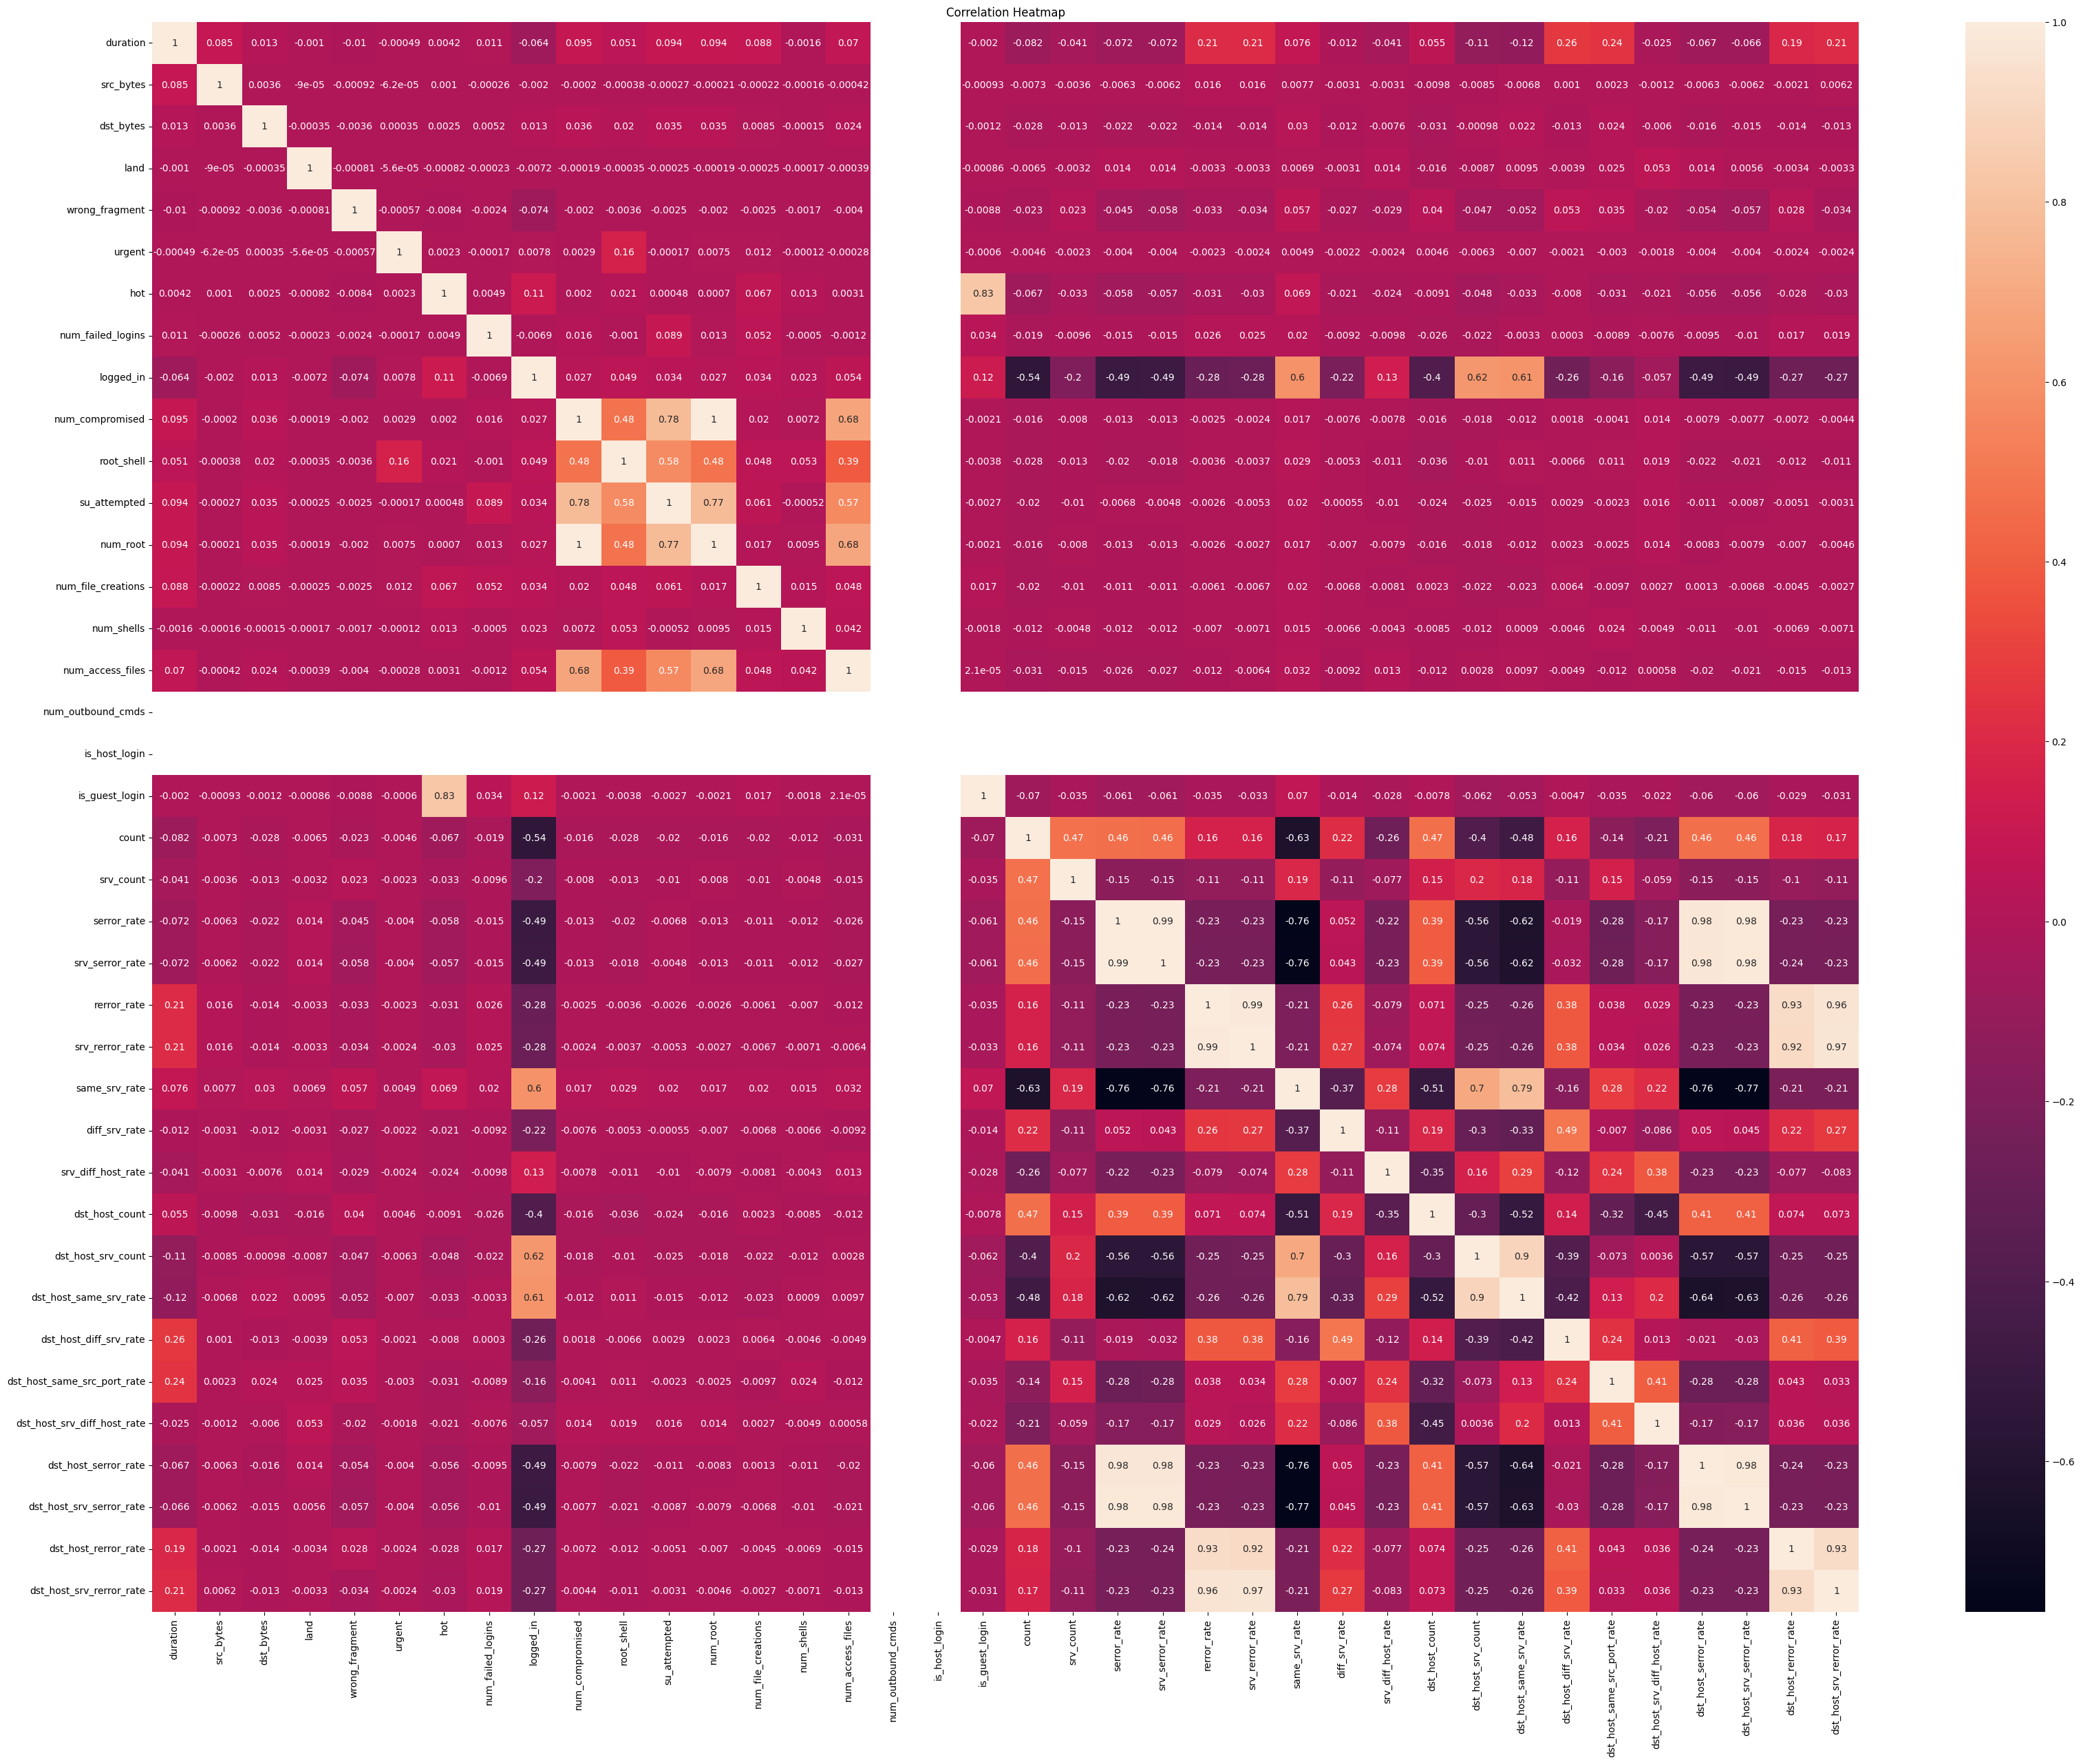

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Summary Statistics
print("Summary Statistics:")
print(train.describe())

# Missing Values Information
missing_data = train.isnull().sum()
if missing_data.any():
    print("\nMissing Values:")
    missing_percentage = (missing_data / len(train)) * 100
    missing_info = missing_data[missing_data > 0]
    missing_percentage = missing_percentage[missing_data > 0]
    for col, count in missing_info.items():
        print(f"{col}: {count} ({round(missing_percentage[col], 3)}%)")
else:
    print("\nNo Missing Values.")

# Correlation Heatmap
plt.figure(figsize=(40, 30))
sns.heatmap(train.corr(), annot=True)
plt.title('Correlation Heatmap')
plt.savefig('heatmap.png')
plt.show()

# Pairplot (Optional: Uncomment if you want to include it)
# sns.pairplot(train)
# plt.title('Pairwise Relationships Plot')
# plt.savefig('pairplot.png')
# plt.show()


In [ ]:
from sklearn.preprocessing import LabelEncoder

def le(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            label_encoder = LabelEncoder()
            df[col] = label_encoder.fit_transform(df[col])

le(train)
le(test)


In [ ]:
train.drop(['num_outbound_cmds'], axis=1, inplace=True)
test.drop(['num_outbound_cmds'], axis=1, inplace=True)
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,1,19,9,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,1
1,0,2,41,9,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,1
2,0,1,46,5,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0
3,0,1,22,9,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,1
4,0,1,22,9,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1


In [ ]:
X_train = train.drop(['protocol_type', 'class'], axis=1)
Y_train = train['class']


In [ ]:
X_train = train.drop(['class'], axis=1)
Y_train = train['class']


In [ ]:
# Load the CSV file
data = pd.read_csv('/content/Train_data.csv')

# Print the first few rows of the DataFrame
print(data.head())

# Print the names of the columns
print(data.columns)

# Based on the above output, identify the correct column(s) and apply preprocessing
# Example: If 'protocol_type' is the categorical column you want to encode
label_encoder = LabelEncoder()
data['protocol_type'] = label_encoder.fit_transform(data['protocol_type'])

# Continue with PCA or other analysis


   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  25   
1               0       0    0  ...                   1   
2               0       0    0  ...                  26   
3               0       0    0  ...                 255   
4               0       0    0  ...                 255   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.17                    0.03   
1                    0.00                    0.60   
2                    0.10                    0.05   


In [ ]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

# Identify non-numeric columns and apply label encoding
for col in data.columns:
    if data[col].dtype == 'object':
        label_encoder = LabelEncoder()
        data[col] = label_encoder.fit_transform(data[col])

# Handle any missing values (if necessary)
data = data.fillna(method='ffill')

# Perform PCA on the features
n_components = 39 # Specify the number of components to keep
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(data)

# X_pca now contains the transformed features with the specified number of principal components


In [ ]:
feature_names = data.columns.tolist()

# Perform PCA on the features
n_components = 39  # Specify the number of components to keep
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(data)

# Retrieve the names of the features contributing to each principal component
principal_components = pca.components_
for i, principal_component in enumerate(principal_components):
    sorted_indices = principal_component.argsort()[::-1]
    sorted_feature_names = [feature_names[idx] for idx in sorted_indices]
    print(f"Principal Component {i+1} Top Features:")
    print(sorted_feature_names[:10])  # Print the top 5 features contributing to each principal component
    print()

Principal Component 1 Top Features:
['src_bytes', 'dst_bytes', 'duration', 'service', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'hot', 'dst_host_srv_rerror_rate', 'dst_host_same_src_port_rate']

Principal Component 2 Top Features:
['dst_bytes', 'duration', 'num_root', 'num_compromised', 'flag', 'same_srv_rate', 'dst_host_same_srv_rate', 'dst_host_same_src_port_rate', 'logged_in', 'class']

Principal Component 3 Top Features:
['duration', 'dst_host_count', 'service', 'num_root', 'num_compromised', 'dst_host_same_src_port_rate', 'srv_rerror_rate', 'rerror_rate', 'dst_host_srv_rerror_rate', 'dst_host_rerror_rate']

Principal Component 4 Top Features:
['count', 'dst_host_count', 'srv_count', 'service', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'serror_rate', 'srv_serror_rate', 'dst_host_srv_rerror_rate', 'srv_rerror_rate']

Principal Component 5 Top Features:
['dst_host_srv_count', 'srv_count', 'count', 'dst_host_count', 'flag', 'duration', 'dst_host_same_srv_rate', 'cla

In [ ]:
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance by Components: {explained_variance}")
print(f"Total Explained Variance: {explained_variance.sum()}")


Explained Variance by Components: [9.98642928e-01 1.35583441e-03 1.23106897e-06 3.68673197e-09
 1.75052575e-09 1.08631081e-09 3.83030829e-10 4.10448120e-11
 3.23565953e-11 8.02795971e-13 6.25857432e-13 9.46538202e-14
 4.77468466e-14 3.28852198e-14 2.23395664e-14 2.11069479e-14
 1.19258266e-14 8.88871120e-15 6.35494624e-15 6.32712877e-15
 5.57375369e-15 4.24143608e-15 3.34866300e-15 2.17324640e-15
 1.48830734e-15 1.11391324e-15 9.58819664e-16 9.38617451e-16
 8.72816146e-16 6.26674982e-16 4.72214796e-16 4.57043075e-16
 3.46717025e-16 2.43774317e-16 2.05770870e-16 1.28278300e-16
 1.08201855e-16 6.03375273e-17 1.34823953e-17]
Total Explained Variance: 0.9999999999999998


In [ ]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

def f_importance(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)

    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.title('Feature Importance for PCA')
    plt.show()

# Assuming you have prepared your data and stored the feature names in 'feature_names'

# Perform PCA on the features
n_components = 39  # Specify the number of components to keep
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(data)

# Retrieve the names of the features contributing to each principal component
principal_components = pca.components_
for i, principal_component in enumerate(principal_components):
    sorted_indices = principal_component.argsort()[::-1]
    sorted_feature_names = [feature_names[idx] for idx in sorted_indices]
    print(f"Principal Component {i+1} Top Features:")
    print(sorted_feature_names[:5])  # Print the top 5 features contributing to each principal component
    print()

# Visualize the feature importance using the PCA-transformed features
f_importance(abs(dt.feature_importances_), sorted_feature_names, top=7)


Principal Component 1 Top Features:
['src_bytes', 'dst_bytes', 'duration', 'service', 'rerror_rate']

Principal Component 2 Top Features:
['dst_bytes', 'duration', 'num_root', 'num_compromised', 'flag']

Principal Component 3 Top Features:
['duration', 'dst_host_count', 'service', 'num_root', 'num_compromised']

Principal Component 4 Top Features:
['count', 'dst_host_count', 'srv_count', 'service', 'dst_host_serror_rate']

Principal Component 5 Top Features:
['dst_host_srv_count', 'srv_count', 'count', 'dst_host_count', 'flag']

Principal Component 6 Top Features:
['count', 'srv_count', 'num_root', 'num_compromised', 'duration']

Principal Component 7 Top Features:
['count', 'dst_host_srv_count', 'service', 'duration', 'logged_in']

Principal Component 8 Top Features:
['num_root', 'num_compromised', 'service', 'dst_host_srv_count', 'srv_count']

Principal Component 9 Top Features:
['num_root', 'num_compromised', 'dst_host_count', 'hot', 'flag']

Principal Component 10 Top Features:
['h

NameError: ignored

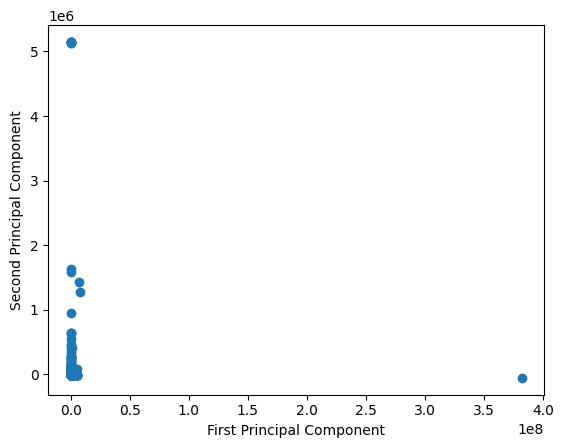

In [ ]:
import matplotlib.pyplot as plt

# If two components
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()


In [ ]:
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
test = scale.fit_transform(test)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Assuming you already have 'X_pca' as the PCA-transformed features and 'target' as the target variable

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, train_size=0.60, random_state=42)




In [ ]:
def objective(trial):
    n_neighbors = trial.suggest_int('KNN_n_neighbors', 2, 16, log=False)
    classifier_obj = KNeighborsClassifier(n_neighbors=n_neighbors)
    classifier_obj.fit(x_train, y_train)
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy

In [ ]:
import optuna
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# Assuming you have prepared your data and target variables (x_train, x_test, y_train, y_test)

def objective(trial):
    n_neighbors = trial.suggest_int('KNN_n_neighbors', 2, 16, log=False)
    classifier_obj = KNeighborsClassifier(n_neighbors=n_neighbors)
    classifier_obj.fit(x_train, y_train)
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy

if __name__ == "__main__":
    # Split your data into training and testing sets if you haven't already
    x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, train_size=0.60, random_state=42)

    # Create an Optuna study and optimize the objective function
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)

    # Print the optimal hyperparameters and the best accuracy achieved
    best_params = study.best_params
    best_accuracy = study.best_value
    print(f"Best Hyperparameters: {best_params}")
    print(f"Best Accuracy: {best_accuracy}")


[I 2023-08-25 10:07:04,072] A new study created in memory with name: no-name-49f726ab-96c6-4520-bd02-a7ab46a9d7ff
[I 2023-08-25 10:07:05,432] Trial 0 finished with value: 0.988687109258708 and parameters: {'KNN_n_neighbors': 15}. Best is trial 0 with value: 0.988687109258708.
[I 2023-08-25 10:07:06,694] Trial 1 finished with value: 0.9895802322119679 and parameters: {'KNN_n_neighbors': 8}. Best is trial 1 with value: 0.9895802322119679.
[I 2023-08-25 10:07:08,385] Trial 2 finished with value: 0.9895802322119679 and parameters: {'KNN_n_neighbors': 8}. Best is trial 1 with value: 0.9895802322119679.
[I 2023-08-25 10:07:10,769] Trial 3 finished with value: 0.9887863451424035 and parameters: {'KNN_n_neighbors': 14}. Best is trial 1 with value: 0.9895802322119679.
[I 2023-08-25 10:07:12,175] Trial 4 finished with value: 0.9891832886771856 and parameters: {'KNN_n_neighbors': 11}. Best is trial 1 with value: 0.9895802322119679.
[I 2023-08-25 10:07:13,444] Trial 5 finished with value: 0.988687

Best Hyperparameters: {'KNN_n_neighbors': 3}
Best Accuracy: 0.9925573087228342


In [ ]:
study_KNN = optuna.create_study(direction='maximize')
study_KNN.optimize(objective, n_trials=1)
print(study_KNN.best_trial)

[I 2023-08-25 10:09:33,650] A new study created in memory with name: no-name-5677dbd9-93af-4109-8feb-de10510569fa
[I 2023-08-25 10:09:35,014] Trial 0 finished with value: 0.9889848169097946 and parameters: {'KNN_n_neighbors': 13}. Best is trial 0 with value: 0.9889848169097946.


FrozenTrial(number=0, state=TrialState.COMPLETE, values=[0.9889848169097946], datetime_start=datetime.datetime(2023, 8, 25, 10, 9, 33, 655172), datetime_complete=datetime.datetime(2023, 8, 25, 10, 9, 35, 14575), params={'KNN_n_neighbors': 13}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'KNN_n_neighbors': IntDistribution(high=16, log=False, low=2, step=1)}, trial_id=0, value=None)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# Assuming you have prepared your data and target variables (x_train, x_test, y_train, y_test)

if __name__ == "__main__":
    # Split your data into training and testing sets

    # Create the KNeighborsClassifier with the best hyperparameters from the study
    best_k = study_KNN.best_trial.params['KNN_n_neighbors']
    KNN_model = KNeighborsClassifier(n_neighbors=best_k)

    # Train the KNeighborsClassifier on the training data
    KNN_model.fit(x_train, y_train)

    # Evaluate the model on the training and test data
    KNN_train_score = KNN_model.score(x_train, y_train)
    KNN_test_score = KNN_model.score(x_test, y_test)

    # Print the results
    print(f"Train Score: {KNN_train_score:.4f}")
    print(f"Test Score: {KNN_test_score:.4f}")


Train Score: 0.9896
Test Score: 0.9890


In [ ]:
import optuna
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# Assuming you have prepared your data and target variables (x_train, x_test, y_train, y_test)

if __name__ == "__main__":
    # Split your data into training and testing sets if you haven't already
    x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, train_size=0.70, random_state=2)

    # Optuna study for hyperparameter optimization

    # Create a KNN model with the best hyperparameters
    KNN_model = KNeighborsClassifier(n_neighbors=study.best_trial.params['KNN_n_neighbors'])
    KNN_model.fit(x_train, y_train)

    # Calculate the train and test scores
    KNN_train_score = KNN_model.score(x_train, y_train)
    KNN_test_score = KNN_model.score(x_test, y_test)

    # Print the results
    print(f"Best Hyperparameters: {study.best_params}")
    print(f"Best Accuracy: {study.best_value}")
    print(f"Train Score: {KNN_train_score}")
    print(f"Test Score: {KNN_test_score}")


Best Hyperparameters: {'KNN_n_neighbors': 3}
Best Accuracy: 0.9925573087228342
Train Score: 0.9961438130883521
Test Score: 0.9919290817676634


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Assuming you have prepared your data and target variables (x_train, x_test, y_train, y_test)

if __name__ == "__main__":

    # Create and train the Logistic Regression model
    lg_model = LogisticRegression(random_state=42)
    lg_model.fit(x_train, y_train)

    # Evaluate the model on the test data
    lg_train_score = lg_model.score(x_train, y_train)
    lg_test_score = lg_model.score(x_test, y_test)

    # Print the results
    print(f"Train Score: {lg_train_score}")
    print(f"Test Score: {lg_test_score}")


Train Score: 0.9545196778949756
Test Score: 0.9556761047896268


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
lg_train, lg_test = lg_model.score(x_train , y_train), lg_model.score(x_test , y_test)

print(f"Training Score: {lg_train}")
print(f"Test Score: {lg_test}")

Training Score: 0.9545196778949756
Test Score: 0.9556761047896268


In [ ]:
#desison tree

In [ ]:
if __name__ == "__main__":


    # Optuna study for hyperparameter optimization
    def objective(trial):
        dt_max_depth = trial.suggest_int('dt_max_depth', 2, 32, log=False)
        dt_max_features = trial.suggest_int('dt_max_features', 2, 10, log=False)
        classifier_obj = DecisionTreeClassifier(max_features=dt_max_features, max_depth=dt_max_depth)
        classifier_obj.fit(x_train, y_train)
        accuracy = classifier_obj.score(x_test, y_test)
        return accuracy

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)

    # Create and train the Decision Tree model with the best hyperparameters
    dt = DecisionTreeClassifier(max_features=study.best_trial.params['dt_max_features'],
                                max_depth=study.best_trial.params['dt_max_depth'])
    dt.fit(x_train, y_train)

    # Calculate the train and test scores
    dt_train_score = dt.score(x_train, y_train)
    dt_test_score = dt.score(x_test, y_test)

    # Print the results
    print(f"Best Hyperparameters: {study.best_params}")
    print(f"Best Accuracy: {study.best_value}")
    print(f"Train Score: {dt_train_score}")
    print(f"Test Score: {dt_test_score}")


[I 2023-08-25 10:09:43,752] A new study created in memory with name: no-name-5ace0df9-54dc-4d01-9b86-828a550486d8
[I 2023-08-25 10:09:43,789] Trial 0 finished with value: 0.9846520243450648 and parameters: {'dt_max_depth': 6, 'dt_max_features': 5}. Best is trial 0 with value: 0.9846520243450648.
[I 2023-08-25 10:09:43,826] Trial 1 finished with value: 0.9924583223074888 and parameters: {'dt_max_depth': 21, 'dt_max_features': 7}. Best is trial 1 with value: 0.9924583223074888.
[I 2023-08-25 10:09:43,848] Trial 2 finished with value: 0.9903413601481873 and parameters: {'dt_max_depth': 30, 'dt_max_features': 2}. Best is trial 1 with value: 0.9924583223074888.
[I 2023-08-25 10:09:43,872] Trial 3 finished with value: 0.9645408838317016 and parameters: {'dt_max_depth': 7, 'dt_max_features': 6}. Best is trial 1 with value: 0.9924583223074888.
[I 2023-08-25 10:09:43,891] Trial 4 finished with value: 0.9891505689335803 and parameters: {'dt_max_depth': 19, 'dt_max_features': 3}. Best is trial 1 

Best Hyperparameters: {'dt_max_depth': 29, 'dt_max_features': 10}
Best Accuracy: 0.9960306959513099
Train Score: 1.0
Test Score: 0.9912675310928817


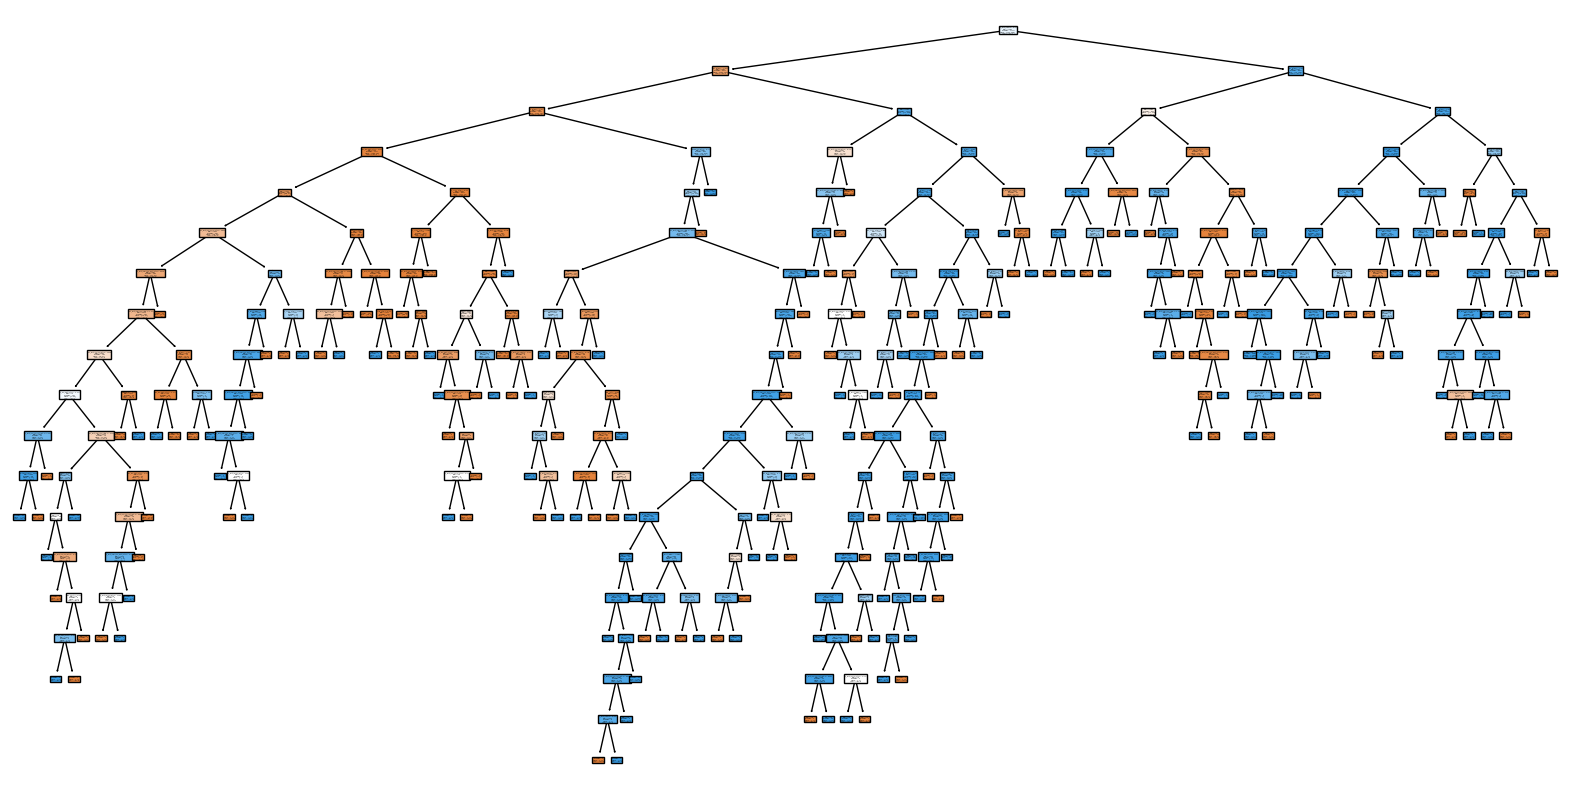

In [ ]:
import matplotlib.pyplot as plt
from sklearn import tree

# Assuming you have already created and trained the Decision Tree model 'dt'

# Set the figure size and font size for better visualization
fig, ax = plt.subplots(figsize=(20, 10))
plt.rcParams.update({'font.size': 12})

# Plot the Decision Tree
tree.plot_tree(dt, filled=True, feature_names=data.columns, class_names=['Class 0', 'Class 1'], ax=ax)

# Display the plot
plt.show()


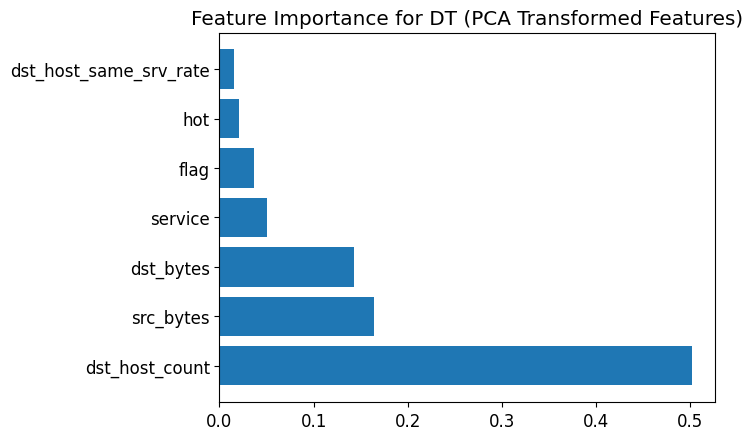

In [ ]:
from matplotlib import pyplot as plt

def f_importance(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)

    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.title('Feature Importance for DT (PCA Transformed Features)')
    plt.show()

# Assuming you already have the transformed PCA features in X_pca and the column names in feature_names
# Also, replace 'dt' with your trained Decision Tree model

# Calculate the feature importance scores using the trained Decision Tree model
feature_importance = dt.feature_importances_

# Visualize the feature importance using the transformed PCA features
f_importance(feature_importance, feature_names, top=7)


In [ ]:
#SKLEARN gradient boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

# Assuming you have prepared your data and target variables (x_train, x_test, y_train, y_test)

if __name__ == "__main__":
    # Split your data into training and testing sets if you haven't already

    # Create and train the Gradient Boosting classifier
    SKGB = GradientBoostingClassifier(random_state=42)
    SKGB.fit(x_train, y_train)

    # Evaluate the model on the test data
    SKGB_train_score = SKGB.score(x_train, y_train)
    SKGB_test_score = SKGB.score(x_test, y_test)

    # Print the results
    print(f"Train Score: {SKGB_train_score:.4f}")
    print(f"Test Score: {SKGB_test_score:.4f}")


Train Score: 0.9967
Test Score: 0.9940


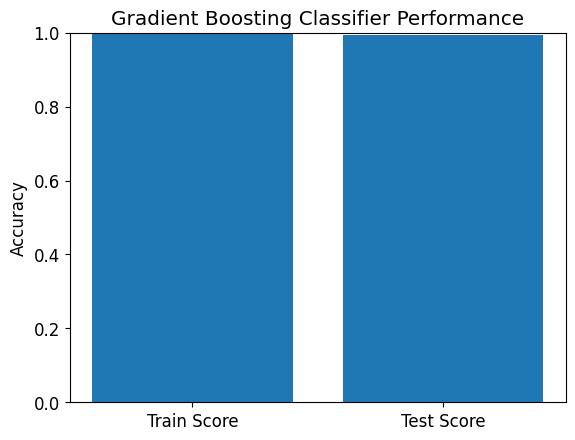

In [ ]:
    scores = [SKGB_train_score, SKGB_test_score]
    labels = ['Train Score', 'Test Score']

    plt.bar(labels, scores)
    plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
    plt.ylabel('Accuracy')
    plt.title('Gradient Boosting Classifier Performance')
    plt.show()

In [ ]:
#xgboost

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# Assuming you have prepared your data and target variables (x_train, x_test, y_train, y_test)

if __name__ == "__main__":


    # Create and train the XGBoost classifier
    xgb_model = XGBClassifier(objective="binary:logistic", random_state=42)
    xgb_model.fit(x_train, y_train)

    # Evaluate the model on the test data
    xgb_train_score = xgb_model.score(x_train, y_train)
    xgb_test_score = xgb_model.score(x_test, y_test)

    # Print the results
    print(f"Train Score: {xgb_train_score:.4f}")
    print(f"Test Score: {xgb_test_score:.4f}")


Train Score: 1.0000
Test Score: 0.9972


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Ridge

# Assuming you have prepared your data and target variables (data, target)

if __name__ == "__main__":

    # Create and train the XGBoost classifier with L2 regularization (Ridge)
    xgb_model = XGBClassifier(objective="binary:logistic", random_state=42)
    ridge_model = Ridge(alpha=0.01)  # Adjust the alpha value for regularization strength

    # Apply k-fold cross-validation (5 folds in this example)
    cv_scores = cross_val_score(xgb_model, data,Y_train, cv=5)

    # Print the cross-validation scores
    print("Cross-validation scores:", cv_scores)
    print("Mean Cross-validation score:", cv_scores.mean())

    # Fit the XGBoost classifier and Ridge model on the training data
    xgb_model.fit(x_train, y_train)
    ridge_model.fit(x_train, y_train)

    # Evaluate the models on the test data
    xgb_test_score = xgb_model.score(x_test, y_test)
    ridge_test_score = ridge_model.score(x_test, y_test)

    # Print the test scores
    print(f"XGBoost Test Score: {xgb_test_score:.4f}")
    print(f"Ridge Test Score: {ridge_test_score:.4f}")


Cross-validation scores: [1. 1. 1. 1. 1.]
Mean Cross-validation score: 1.0
XGBoost Test Score: 0.9972
Ridge Test Score: 0.8378


In [ ]:
#Light gradient

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split

# Assuming you have prepared your data and target variables (x_train, x_test, y_train, y_test)

if __name__ == "__main__":

    # Create and train the LGBMClassifier
    lgb_model = LGBMClassifier(random_state=42)
    lgb_model.fit(x_train, y_train)

    # Evaluate the model on the test data
    lgb_train_score = lgb_model.score(x_train, y_train)
    lgb_test_score = lgb_model.score(x_test, y_test)

    # Print the results
    print(f"Train Score: {lgb_train_score:.4f}")
    print(f"Test Score: {lgb_test_score:.4f}")


[LightGBM] [Info] Number of positive: 9389, number of negative: 8245
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2751
[LightGBM] [Info] Number of data points in the train set: 17634, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.532437 -> initscore=0.129932
[LightGBM] [Info] Start training from score 0.129932
Train Score: 1.0000
Test Score: 0.9976


In [ ]:
#SKLearn AdaBoost Model

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split

# Assuming you have prepared your data and target variables (x_train, x_test, y_train, y_test)

if __name__ == "__main__":
    # Split your data into training and testing sets

    # Create and train the AdaBoostClassifier
    ab_model = AdaBoostClassifier(random_state=42)
    ab_model.fit(x_train, y_train)

    # Evaluate the model on the test data
    ab_train_score = ab_model.score(x_train, y_train)
    ab_test_score = ab_model.score(x_test, y_test)

    # Print the results
    print(f"Train Score: {ab_train_score:.4f}")
    print(f"Test Score: {ab_test_score:.4f}")


Train Score: 0.9875
Test Score: 0.9886


In [ ]:
#CatBoost Classifier Model

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

# Assuming you have prepared your data and target variables (x_train, x_test, y_train, y_test)

if __name__ == "__main__":
    # Split your data into training and testing sets

    # Create and train the CatBoostClassifier
    cb_model = CatBoostClassifier(verbose=0)
    cb_model.fit(x_train, y_train)

    # Evaluate the model on the test data
    cb_train_score = cb_model.score(x_train, y_train)
    cb_test_score = cb_model.score(x_test, y_test)

    # Print the results
    print(f"Train Score: {cb_train_score:.4f}")
    print(f"Test Score: {cb_test_score:.4f}")


Train Score: 0.9991
Test Score: 0.9962


In [ ]:
#Naive Baye Model

In [ ]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split

# Assuming you have prepared your data and target variables (x_train, x_test, y_train, y_test)

if __name__ == "__main__":
    # Split your data into training and testing sets

    # Create and train the Bernoulli Naive Bayes Classifier
    BNB_model = BernoulliNB()
    BNB_model.fit(x_train, y_train)

    # Evaluate the model on the test data
    BNB_train_score = BNB_model.score(x_train, y_train)
    BNB_test_score = BNB_model.score(x_test, y_test)

    # Print the results
    print(f"Train Score: {BNB_train_score:.4f}")
    print(f"Test Score: {BNB_test_score:.4f}")


Train Score: 0.8959
Test Score: 0.8947


In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

# Assuming you have prepared your data and target variables (data, target)

if __name__ == "__main__":
    # Split your data into training and testing sets

    # Create the individual classifiers
    KNN_model = KNeighborsClassifier(n_neighbors=5)
    xgb_model = XGBClassifier(objective="binary:logistic", random_state=42)
    rf = RandomForestClassifier(random_state=42)
    dt = DecisionTreeClassifier(random_state=42)
    lgb_model = LGBMClassifier(random_state=42)
    ab_model = AdaBoostClassifier(random_state=42)
    cb_model = CatBoostClassifier(verbose=0)

    # Create the VotingClassifier with "hard" voting
    v_clf = VotingClassifier(estimators=[
        ('KNeighborsClassifier', KNN_model),
        ("XGBClassifier", xgb_model),
        ("RandomForestClassifier", rf),
        ("DecisionTree", dt),
        ("XGBoost", xgb_model),
        ("LightGB", lgb_model),
        ("AdaBoost", ab_model),
        ("Catboost", cb_model)],
        voting="hard")

    # Train the VotingClassifier on the training data
    v_clf.fit(x_train, y_train)

    # Evaluate the model on the test data
    v_clf_train_score = v_clf.score(x_train, y_train)
    v_clf_test_score = v_clf.score(x_test, y_test)

    # Print the results
    print(f"Train Score: {v_clf_train_score:.4f}")
    print(f"Test Score: {v_clf_test_score:.4f}")


[LightGBM] [Info] Number of positive: 9389, number of negative: 8245
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2751
[LightGBM] [Info] Number of data points in the train set: 17634, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.532437 -> initscore=0.129932
[LightGBM] [Info] Start training from score 0.129932
Train Score: 1.0000
Test Score: 0.9970


In [ ]:
data = [["KNN", KNN_train_score, KNN_test_score],
        ["Logistic Regression", lg_train, lg_test],
        ["Decision Tree", dt_train_score, dt_test_score],
     #   ["Random Forest", rf_train_score, rf_test_score],
        ["GBM", SKGB_train_score, SKGB_test_score],
        ["XGBM", xgb_train_score, xgb_test_score],
        ["Adaboost", ab_train_score, ab_test_score],
        ["light GBM", lgb_train_score, lgb_test_score],
        ["CatBoost", cb_train_score, cb_test_score],
        ["Naive Baye Model", BNB_train_score, BNB_test_score],
        ["Voting",v_clf_train_score,v_clf_test_score]]
       # ["SVM", SVM_train, SVM_test]]

col_names = ["Model", "Train Score", "Test Score"]
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

╒═════════════════════╤═══════════════╤══════════════╕
│ Model               │   Train Score │   Test Score │
╞═════════════════════╪═══════════════╪══════════════╡
│ KNN                 │      0.996144 │     0.991929 │
├─────────────────────┼───────────────┼──────────────┤
│ Logistic Regression │      0.95452  │     0.955676 │
├─────────────────────┼───────────────┼──────────────┤
│ Decision Tree       │      1        │     0.991268 │
├─────────────────────┼───────────────┼──────────────┤
│ GBM                 │      0.996654 │     0.994046 │
├─────────────────────┼───────────────┼──────────────┤
│ XGBM                │      1        │     0.997221 │
├─────────────────────┼───────────────┼──────────────┤
│ Adaboost            │      0.987524 │     0.988621 │
├─────────────────────┼───────────────┼──────────────┤
│ light GBM           │      1        │     0.997618 │
├─────────────────────┼───────────────┼──────────────┤
│ CatBoost            │      0.999093 │     0.996163 │
├─────────

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Assuming you have prepared your data and target variables (data, target)

# Split your data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, train_size=0.60, random_state=42)


# Define a list of model instances
models_list = [
    KNeighborsClassifier(n_neighbors=5),
    XGBClassifier(objective="binary:logistic", random_state=42),
    RandomForestClassifier(random_state=42),
    DecisionTreeClassifier(random_state=42),
    LGBMClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
    CatBoostClassifier(verbose=0)
]

# Evaluate and print metrics for each model
for model in models_list:
    model_name = model.__class__.__name__
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')  # Calculate weighted F1 score

    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Print confusion matrix and classification report
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print("Classification Report:")
    #print(classification_report(y_test, y_pred, target_names=data.target_names))

    print("-" * 50)


Model: KNeighborsClassifier
Accuracy: 0.9914
F1 Score: 0.9914
Confusion Matrix:
[[4640   48]
 [  39 5350]]
Classification Report:
--------------------------------------------------
Model: XGBClassifier
Accuracy: 0.9976
F1 Score: 0.9976
Confusion Matrix:
[[4672   16]
 [   8 5381]]
Classification Report:
--------------------------------------------------
Model: RandomForestClassifier
Accuracy: 0.9976
F1 Score: 0.9976
Confusion Matrix:
[[4670   18]
 [   6 5383]]
Classification Report:
--------------------------------------------------
Model: DecisionTreeClassifier
Accuracy: 0.9942
F1 Score: 0.9942
Confusion Matrix:
[[4664   24]
 [  34 5355]]
Classification Report:
--------------------------------------------------
[LightGBM] [Info] Number of positive: 8060, number of negative: 7055
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `for

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Assuming you have prepared your data and target variables (data, target)

# Split your data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, train_size=0.60, random_state=42)
# Define a list of model instances and their names
models_list = [
    ("KNeighbors", KNeighborsClassifier(n_neighbors=5)),
    ("XGBoost", XGBClassifier(objective="binary:logistic", random_state=42)),
    ("RandomForest", RandomForestClassifier(random_state=42)),
    ("DecisionTree", DecisionTreeClassifier(random_state=42)),
    ("LGBM", LGBMClassifier(random_state=42)),
    ("AdaBoost", AdaBoostClassifier(random_state=42)),
    ("CatBoost", CatBoostClassifier(verbose=0))
]

# Create an empty DataFrame to store metrics
metrics_df = pd.DataFrame(columns=["Model", "Accuracy", "F1 Score", "Confusion Matrix"])

# Evaluate metrics for each model and populate the DataFrame
for model_name, model in models_list:
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    confusion = confusion_matrix(y_test, y_pred)

    metrics_df = metrics_df.append({"Model": model_name, "Accuracy": accuracy, "F1 Score": f1, "Confusion Matrix": confusion}, ignore_index=True)

# Print the DataFrame with metrics
print(metrics_df)


<ipython-input-50-fc4c6ac49111>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({"Model": model_name, "Accuracy": accuracy, "F1 Score": f1, "Confusion Matrix": confusion}, ignore_index=True)
<ipython-input-50-fc4c6ac49111>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({"Model": model_name, "Accuracy": accuracy, "F1 Score": f1, "Confusion Matrix": confusion}, ignore_index=True)
<ipython-input-50-fc4c6ac49111>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({"Model": model_name, "Accuracy": accuracy, "F1 Score": f1, "Confusion Matrix": confusion}, ignore_index=True)
<ipython-input-50-fc4c6ac49111>:38: FutureWarning: The frame.

[LightGBM] [Info] Number of positive: 8060, number of negative: 7055
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2751
[LightGBM] [Info] Number of data points in the train set: 15115, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.533245 -> initscore=0.133177
[LightGBM] [Info] Start training from score 0.133177


<ipython-input-50-fc4c6ac49111>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({"Model": model_name, "Accuracy": accuracy, "F1 Score": f1, "Confusion Matrix": confusion}, ignore_index=True)
<ipython-input-50-fc4c6ac49111>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({"Model": model_name, "Accuracy": accuracy, "F1 Score": f1, "Confusion Matrix": confusion}, ignore_index=True)


          Model  Accuracy  F1 Score          Confusion Matrix
0    KNeighbors  0.991366  0.991366  [[4640, 48], [39, 5350]]
1       XGBoost  0.997618  0.997618   [[4672, 16], [8, 5381]]
2  RandomForest  0.997618  0.997618   [[4670, 18], [6, 5383]]
3  DecisionTree  0.994244  0.994245  [[4664, 24], [34, 5355]]
4          LGBM  0.997916  0.997916  [[4677, 11], [10, 5379]]
5      AdaBoost  0.989183  0.989182  [[4627, 61], [48, 5341]]
6      CatBoost  0.997817  0.997817   [[4671, 17], [5, 5384]]


<ipython-input-50-fc4c6ac49111>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({"Model": model_name, "Accuracy": accuracy, "F1 Score": f1, "Confusion Matrix": confusion}, ignore_index=True)


In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Assuming you have prepared your data and target variables (data, target)

# Split your data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, train_size=0.60, random_state=42)

# Define a list of model instances and their names
models_list = [
    ("KNeighbors", KNeighborsClassifier(n_neighbors=5)),
    ("XGBoost", XGBClassifier(objective="binary:logistic", random_state=42)),
    ("RandomForest", RandomForestClassifier(random_state=42)),
    ("DecisionTree", DecisionTreeClassifier(random_state=42)),
    ("LGBM", LGBMClassifier(random_state=42)),
    ("AdaBoost", AdaBoostClassifier(random_state=42)),
    ("CatBoost", CatBoostClassifier(verbose=0))
]

# Create an empty DataFrame to store metrics
metrics_df = pd.DataFrame(columns=["Model", "Accuracy", "F1 Score", "Precision", "Recall", "Confusion Matrix"])

# Evaluate metrics for each model and populate the DataFrame
for model_name, model in models_list:
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred


                          )
    confusion = confusion_matrix(y_test, y_pred)

    metrics_df = metrics_df.append({"Model": model_name, "Accuracy": accuracy, "F1 Score": f1, "Precision": precision, "Recall": recall, "Confusion Matrix": confusion}, ignore_index=True)

# Print the DataFrame with metrics
print(metrics_df)


<ipython-input-51-a13cf9ee94e6>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({"Model": model_name, "Accuracy": accuracy, "F1 Score": f1, "Precision": precision, "Recall": recall, "Confusion Matrix": confusion}, ignore_index=True)
<ipython-input-51-a13cf9ee94e6>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({"Model": model_name, "Accuracy": accuracy, "F1 Score": f1, "Precision": precision, "Recall": recall, "Confusion Matrix": confusion}, ignore_index=True)
<ipython-input-51-a13cf9ee94e6>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({"Model": model_name, "Accuracy": accuracy, "F1 Score": f1, "Precision": precision, "Rec

[LightGBM] [Info] Number of positive: 8060, number of negative: 7055
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003720 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2751
[LightGBM] [Info] Number of data points in the train set: 15115, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.533245 -> initscore=0.133177
[LightGBM] [Info] Start training from score 0.133177


<ipython-input-51-a13cf9ee94e6>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({"Model": model_name, "Accuracy": accuracy, "F1 Score": f1, "Precision": precision, "Recall": recall, "Confusion Matrix": confusion}, ignore_index=True)
<ipython-input-51-a13cf9ee94e6>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({"Model": model_name, "Accuracy": accuracy, "F1 Score": f1, "Precision": precision, "Recall": recall, "Confusion Matrix": confusion}, ignore_index=True)


          Model  Accuracy  F1 Score  Precision    Recall  \
0    KNeighbors  0.991366  0.991935   0.991108  0.992763   
1       XGBoost  0.997618  0.997775   0.997035  0.998515   
2  RandomForest  0.997618  0.997776   0.996667  0.998887   
3  DecisionTree  0.994244  0.994614   0.995538  0.993691   
4          LGBM  0.997916  0.998052   0.997959  0.998144   
5      AdaBoost  0.989183  0.989899   0.988708  0.991093   
6      CatBoost  0.997817  0.997961   0.996852  0.999072   

           Confusion Matrix  
0  [[4640, 48], [39, 5350]]  
1   [[4672, 16], [8, 5381]]  
2   [[4670, 18], [6, 5383]]  
3  [[4664, 24], [34, 5355]]  
4  [[4677, 11], [10, 5379]]  
5  [[4627, 61], [48, 5341]]  
6   [[4671, 17], [5, 5384]]  


<ipython-input-51-a13cf9ee94e6>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({"Model": model_name, "Accuracy": accuracy, "F1 Score": f1, "Precision": precision, "Recall": recall, "Confusion Matrix": confusion}, ignore_index=True)


In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import BernoulliNB

# Assuming you have prepared your data and target variables (data, target)

# Split your data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, train_size=0.60, random_state=42)

# Model instances
models_list = [
    ("KNN", KNeighborsClassifier(n_neighbors=5)),
    ("Logistic Regression", LogisticRegression(random_state=42)),
    ("Decision Tree", DecisionTreeClassifier(max_features=10, max_depth=19, random_state=42)),
    ("GBM", GradientBoostingClassifier(random_state=42)),
    ("XGBM", XGBClassifier(objective="binary:logistic", random_state=42)),
    ("Adaboost", AdaBoostClassifier(random_state=42)),
    ("light GBM", LGBMClassifier(random_state=42)),
    ("CatBoost", CatBoostClassifier(verbose=0, random_state=42)),
    ("Naive Baye Model", BernoulliNB()),
    ("Voting", VotingClassifier(estimators=[('KNeighborsClassifier', KNeighborsClassifier(n_neighbors=5)),
                                            ("XGBClassifier", XGBClassifier(objective="binary:logistic", random_state=42)),
                                            ("DecisionTree", DecisionTreeClassifier(max_features=10, max_depth=19, random_state=42)),
                                            ("GBM", GradientBoostingClassifier(random_state=42)),
                                            ("XGBoost", XGBClassifier(objective="binary:logistic", random_state=42)),
                                            ("LightGB", LGBMClassifier(random_state=42)),
                                            ("AdaBoost", AdaBoostClassifier(random_state=42)),
                                            ("Catboost", CatBoostClassifier(verbose=0, random_state=42))],
                                voting="hard"))
]

# Create an empty DataFrame to store metrics
metrics_df = pd.DataFrame(columns=["Model", "Accuracy", "F1 Score", "Precision", "Recall"])

# Evaluate metrics for each model and populate the DataFrame
for model_name, model in models_list:
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    metrics_df = metrics_df.append({"Model": model_name, "Accuracy": accuracy, "F1 Score": f1, "Precision": precision, "Recall": recall}, ignore_index=True)

# Print the DataFrame with metrics
print(metrics_df)


<ipython-input-52-defee453f8aa>:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({"Model": model_name, "Accuracy": accuracy, "F1 Score": f1, "Precision": precision, "Recall": recall}, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-52-defee453f8aa>:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

[LightGBM] [Info] Number of positive: 8060, number of negative: 7055
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2751
[LightGBM] [Info] Number of data points in the train set: 15115, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.533245 -> initscore=0.133177
[LightGBM] [Info] Start training from score 0.133177


<ipython-input-52-defee453f8aa>:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({"Model": model_name, "Accuracy": accuracy, "F1 Score": f1, "Precision": precision, "Recall": recall}, ignore_index=True)
<ipython-input-52-defee453f8aa>:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({"Model": model_name, "Accuracy": accuracy, "F1 Score": f1, "Precision": precision, "Recall": recall}, ignore_index=True)
<ipython-input-52-defee453f8aa>:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({"Model": model_name, "Accuracy": accuracy, "F1 Score": f1, "Precision": precision, "Recall": recall}, ignore_index=True)


[LightGBM] [Info] Number of positive: 8060, number of negative: 7055
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2751
[LightGBM] [Info] Number of data points in the train set: 15115, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.533245 -> initscore=0.133177
[LightGBM] [Info] Start training from score 0.133177
                 Model  Accuracy  F1 Score  Precision    Recall
0                  KNN  0.991366  0.991935   0.991108  0.992763
1  Logistic Regression  0.955939  0.958988   0.954754  0.963258
2        Decision Tree  0.993351  0.993789   0.992960  0.994619
3                  GBM  0.995336  0.995641   0.995180  0.996103
4                 XGBM  0.997618  0.997775   0.997035  0.998515
5             Adaboost  0.989183  0.989899   0.988708  0.99

<ipython-input-52-defee453f8aa>:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({"Model": model_name, "Accuracy": accuracy, "F1 Score": f1, "Precision": precision, "Recall": recall}, ignore_index=True)


In [ ]:
from tabulate import tabulate
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import BernoulliNB

# Assuming you have prepared your data and target variables (data, target)

# Split your data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, train_size=0.60, random_state=42)

# Model instances
models_list = [
    ("KNN", KNeighborsClassifier(n_neighbors=5)),
    ("Logistic Regression", LogisticRegression(random_state=42)),
    ("Decision Tree", DecisionTreeClassifier(max_features=10, max_depth=19, random_state=42)),
    ("GBM", GradientBoostingClassifier(random_state=42)),
    ("XGBM", XGBClassifier(objective="binary:logistic", random_state=42)),
    ("Adaboost", AdaBoostClassifier(random_state=42)),
    ("light GBM", LGBMClassifier(random_state=42)),
    ("CatBoost", CatBoostClassifier(verbose=0, random_state=42)),
    ("Naive Baye Model", BernoulliNB()),
    ("Voting", VotingClassifier(estimators=[('KNeighborsClassifier', KNeighborsClassifier(n_neighbors=5)),
                                            ("XGBClassifier", XGBClassifier(objective="binary:logistic", random_state=42)),
                                            ("DecisionTree", DecisionTreeClassifier(max_features=10, max_depth=19, random_state=42)),
                                            ("GBM", GradientBoostingClassifier(random_state=42)),
                                            ("XGBoost", XGBClassifier(objective="binary:logistic", random_state=42)),
                                            ("LightGB", LGBMClassifier(random_state=42)),
                                            ("AdaBoost", AdaBoostClassifier(random_state=42)),
                                            ("Catboost", CatBoostClassifier(verbose=0, random_state=42))],
                                voting="hard"))
]

# Create an empty DataFrame to store metrics
metrics_df = pd.DataFrame(columns=["Model", "Accuracy", "F1 Score", "Precision", "Recall"])

# Evaluate metrics for each model and populate the DataFrame
for model_name, model in models_list:
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    metrics_df = metrics_df.append({"Model": model_name, "Accuracy": accuracy, "F1 Score": f1, "Precision": precision, "Recall": recall}, ignore_index=True)

# Print the DataFrame with metrics
print(metrics_df)

# Find the model with the highest accuracy
highest_accuracy_model = metrics_df.loc[metrics_df['Accuracy'].idxmax()]['Model']
print(f"Highest Accuracy Model: {highest_accuracy_model}")

# Print the metrics table using tabulate
col_names = ["Model", "Accuracy", "F1 Score", "Precision", "Recall"]
print(tabulate(metrics_df, headers=col_names, tablefmt="fancy_grid"))


<ipython-input-53-e6f2e13d1bac>:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({"Model": model_name, "Accuracy": accuracy, "F1 Score": f1, "Precision": precision, "Recall": recall}, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-53-e6f2e13d1bac>:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

[LightGBM] [Info] Number of positive: 8060, number of negative: 7055
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2751
[LightGBM] [Info] Number of data points in the train set: 15115, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.533245 -> initscore=0.133177
[LightGBM] [Info] Start training from score 0.133177


<ipython-input-53-e6f2e13d1bac>:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({"Model": model_name, "Accuracy": accuracy, "F1 Score": f1, "Precision": precision, "Recall": recall}, ignore_index=True)
<ipython-input-53-e6f2e13d1bac>:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({"Model": model_name, "Accuracy": accuracy, "F1 Score": f1, "Precision": precision, "Recall": recall}, ignore_index=True)
<ipython-input-53-e6f2e13d1bac>:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({"Model": model_name, "Accuracy": accuracy, "F1 Score": f1, "Precision": precision, "Recall": recall}, ignore_index=True)


[LightGBM] [Info] Number of positive: 8060, number of negative: 7055
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2751
[LightGBM] [Info] Number of data points in the train set: 15115, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.533245 -> initscore=0.133177
[LightGBM] [Info] Start training from score 0.133177
                 Model  Accuracy  F1 Score  Precision    Recall
0                  KNN  0.991366  0.991366   0.991367  0.991366
1  Logistic Regression  0.955939  0.955924   0.955952  0.955939
2        Decision Tree  0.993351  0.993351   0.993352  0.993351
3                  GBM  0.995336  0.995336   0.995336  0.995336
4                 XGBM  0.997618  0.997618   0.997619  0.997618
5             Adaboost  0.989183  0.989182   0.989185  0.98

<ipython-input-53-e6f2e13d1bac>:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({"Model": model_name, "Accuracy": accuracy, "F1 Score": f1, "Precision": precision, "Recall": recall}, ignore_index=True)


In [ ]:
print(tabulate(metrics_df, headers=col_names, tablefmt="fancy_grid"))

╒════╤═════════════════════╤════════════╤════════════╤═════════════╤══════════╕
│    │ Model               │   Accuracy │   F1 Score │   Precision │   Recall │
╞════╪═════════════════════╪════════════╪════════════╪═════════════╪══════════╡
│  0 │ KNN                 │   0.991366 │   0.991366 │    0.991367 │ 0.991366 │
├────┼─────────────────────┼────────────┼────────────┼─────────────┼──────────┤
│  1 │ Logistic Regression │   0.955939 │   0.955924 │    0.955952 │ 0.955939 │
├────┼─────────────────────┼────────────┼────────────┼─────────────┼──────────┤
│  2 │ Decision Tree       │   0.993351 │   0.993351 │    0.993352 │ 0.993351 │
├────┼─────────────────────┼────────────┼────────────┼─────────────┼──────────┤
│  3 │ GBM                 │   0.995336 │   0.995336 │    0.995336 │ 0.995336 │
├────┼─────────────────────┼────────────┼────────────┼─────────────┼──────────┤
│  4 │ XGBM                │   0.997618 │   0.997618 │    0.997619 │ 0.997618 │
├────┼─────────────────────┼────────────

In [ ]:
# Find the model with the highest accuracy
highest_accuracy_row = metrics_df.loc[metrics_df['Accuracy'].idxmax()]
highest_accuracy_model = highest_accuracy_row['Model']
highest_accuracy_value = highest_accuracy_row['Accuracy']

print(f"Highest Accuracy Model: {highest_accuracy_model} ({highest_accuracy_value:.4f})")

Highest Accuracy Model: Voting (0.9980)


In [ ]:
from tabulate import tabulate
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import BernoulliNB

# Assuming you have prepared your data and target variables (X_train, Y_train)

# Split your data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, train_size=0.60, random_state=42)

# Model instances
models_list = [
    ("KNN", KNeighborsClassifier(n_neighbors=5)),
    ("Logistic Regression", LogisticRegression(random_state=42)),
    ("Decision Tree", DecisionTreeClassifier(max_features=10, max_depth=19, random_state=42)),
    ("Random Forest", RandomForestClassifier(random_state=42)),
    ("GBM", GradientBoostingClassifier(random_state=42)),
    ("XGBM", XGBClassifier(objective="binary:logistic", random_state=42)),
    ("SVM", SVC(kernel='linear', C=1.0, random_state=42)),
    ("Adaboost", AdaBoostClassifier(random_state=42)),
    ("light GBM", LGBMClassifier(random_state=42)),
    ("CatBoost", CatBoostClassifier(verbose=0, random_state=42)),
    ("Naive Baye Model", BernoulliNB()),
    ("Voting", VotingClassifier(estimators=[('KNeighborsClassifier', KNeighborsClassifier(n_neighbors=5)),
                                            ("XGBClassifier", XGBClassifier(objective="binary:logistic", random_state=42)),
                                            ("DecisionTree", DecisionTreeClassifier(max_features=10, max_depth=19, random_state=42)),
                                            ("RandomForest", RandomForestClassifier(random_state=42)),
                                            ("GBM", GradientBoostingClassifier(random_state=42)),
                                            ("XGBoost", XGBClassifier(objective="binary:logistic", random_state=42)),
                                            ("SVM", SVC(kernel='linear', C=1.0, random_state=42)),
                                            ("LightGB", LGBMClassifier(random_state=42)),
                                            ("AdaBoost", AdaBoostClassifier(random_state=42)),
                                            ("Catboost", CatBoostClassifier(verbose=0, random_state=42))],
                                voting="hard"))
]

# Create an empty DataFrame to store metrics
metrics_df = pd.DataFrame(columns=["Model", "Accuracy", "F1 Score", "Precision", "Recall"])

# Evaluate metrics for each model and populate the DataFrame
for model_name, model in models_list:
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    metrics_df = metrics_df.append({"Model": model_name, "Accuracy": accuracy, "F1 Score": f1, "Precision": precision, "Recall": recall}, ignore_index=True)

# Print the DataFrame with metrics
print(metrics_df)

# Find the model with the highest accuracy
highest_accuracy_row = metrics_df.loc[metrics_df['Accuracy'].idxmax()]
highest_accuracy_model = highest_accuracy_row['Model']
highest_accuracy_value = highest_accuracy_row['Accuracy']

print(f"Highest Accuracy Model: {highest_accuracy_model} ({highest_accuracy_value:.4f})")

# Print the metrics table using tabulate
col_names = ["Model", "Accuracy", "F1 Score", "Precision", "Recall"]
print(tabulate(metrics_df, headers=col_names, tablefmt="fancy_grid"))


<ipython-input-56-ec7898a4dcc2>:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({"Model": model_name, "Accuracy": accuracy, "F1 Score": f1, "Precision": precision, "Recall": recall}, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-56-ec7898a4dcc2>:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

[LightGBM] [Info] Number of positive: 8060, number of negative: 7055
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005773 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2751
[LightGBM] [Info] Number of data points in the train set: 15115, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.533245 -> initscore=0.133177
[LightGBM] [Info] Start training from score 0.133177


<ipython-input-56-ec7898a4dcc2>:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({"Model": model_name, "Accuracy": accuracy, "F1 Score": f1, "Precision": precision, "Recall": recall}, ignore_index=True)
<ipython-input-56-ec7898a4dcc2>:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({"Model": model_name, "Accuracy": accuracy, "F1 Score": f1, "Precision": precision, "Recall": recall}, ignore_index=True)
<ipython-input-56-ec7898a4dcc2>:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({"Model": model_name, "Accuracy": accuracy, "F1 Score": f1, "Precision": precision, "Recall": recall}, ignore_index=True)


[LightGBM] [Info] Number of positive: 8060, number of negative: 7055
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2751
[LightGBM] [Info] Number of data points in the train set: 15115, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.533245 -> initscore=0.133177
[LightGBM] [Info] Start training from score 0.133177
                  Model  Accuracy  F1 Score  Precision    Recall
0                   KNN  0.991366  0.991366   0.991367  0.991366
1   Logistic Regression  0.955939  0.955924   0.955952  0.955939
2         Decision Tree  0.993351  0.993351   0.993352  0.993351
3         Random Forest  0.997618  0.997618   0.997621  0.997618
4                   GBM  0.995336  0.995336   0.995336  0.995336
5                  XGBM  0.997618  0.997618   0.99761

<ipython-input-56-ec7898a4dcc2>:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({"Model": model_name, "Accuracy": accuracy, "F1 Score": f1, "Precision": precision, "Recall": recall}, ignore_index=True)


In [ ]:
print(tabulate(metrics_df, headers=col_names, tablefmt="fancy_grid"))

╒════╤═════════════════════╤════════════╤════════════╤═════════════╤══════════╕
│    │ Model               │   Accuracy │   F1 Score │   Precision │   Recall │
╞════╪═════════════════════╪════════════╪════════════╪═════════════╪══════════╡
│  0 │ KNN                 │   0.991366 │   0.991366 │    0.991367 │ 0.991366 │
├────┼─────────────────────┼────────────┼────────────┼─────────────┼──────────┤
│  1 │ Logistic Regression │   0.955939 │   0.955924 │    0.955952 │ 0.955939 │
├────┼─────────────────────┼────────────┼────────────┼─────────────┼──────────┤
│  2 │ Decision Tree       │   0.993351 │   0.993351 │    0.993352 │ 0.993351 │
├────┼─────────────────────┼────────────┼────────────┼─────────────┼──────────┤
│  3 │ Random Forest       │   0.997618 │   0.997618 │    0.997621 │ 0.997618 │
├────┼─────────────────────┼────────────┼────────────┼─────────────┼──────────┤
│  4 │ GBM                 │   0.995336 │   0.995336 │    0.995336 │ 0.995336 │
├────┼─────────────────────┼────────────